In [187]:
from PIL import Image, ImageDraw
import random
import numpy as np
import pandas as pd
from time import time
import pathlib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data.dataloader import DataLoader
from torch import nn
from torchvision import transforms

# Criando um dataset de imagens simples

In [283]:
def criar_imagem(tipo, n):
    img_h = 60
    cor = (random.randint(0,150),random.randint(0,150),random.randint(0,150))
    img_pil = Image.new('RGB', (img_w, img_h), (255, 255, 255))
    draw = ImageDraw.Draw(img_pil)
    lado_q = random.randint(15, 30)
    x, y = random.randint(0, img_w-lado_q), random.randint(0, img_h-lado_q)
    if (tipo == 0):
        draw.rectangle((x, y, x+lado_q, y+lado_q), fill=cor)
        img_pil.save('./images/square/img_{}.jpg'.format(n))
    else:
        draw.ellipse((x, y, x+lado_q, y+lado_q), fill=cor)
        img_pil.save('./images/circle/img_{}.jpg'.format(n))

retornou circulo


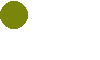

In [287]:
def retornar_imagem():
    img_h = 60
    cor = (random.randint(0,150),random.randint(0,150),random.randint(0,150))
    img_pil = Image.new('RGB', (img_w, img_h), (255, 255, 255))
    draw = ImageDraw.Draw(img_pil)
    lado_q = random.randint(15, 30)
    x, y = random.randint(0, img_w-lado_q), random.randint(0, img_h-lado_q)
    if (random.random() >= 0.5):
        draw.rectangle((x, y, x+lado_q, y+lado_q), fill=cor)
        print ('retornou quadrado')
    else:
        print ('retornou circulo')
        draw.ellipse((x, y, x+lado_q, y+lado_q), fill=cor)
    
    
    return img_pil

retornar_imagem()

In [64]:
for k in range(100):
    criar_imagem(0, k)
    criar_imagem(1, k)

# Pegando agora as imagens

In [72]:
images = list(pathlib.Path('./images').glob('*/*.jpg'))
images = [str(i) for i in images]

In [80]:
idx2label = {0: 'circle', 1: 'square'}
label2idx = {'circle': 0, 'square': 1}

circle


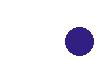

In [94]:
# Criando um dataset customizado
class customDataset(Dataset):

    def __init__(self, lista):
        self.lista = lista
    
    def __getitem__(self, index):
        caminho = self.lista[index]
        if (caminho.find('circle', 0) != -1):
            label = label2idx['circle']
        else:
            label = label2idx['square']
        
        img_pil = Image.open(caminho)
        return img_pil, label
    
    def __len__(self):
        return len(self.lista)

customds = customDataset(images)
img_pil, label = random.choice(customds)
print(idx2label[label])
img_pil

# Criando um dataloader e sua função de utilização

In [162]:
img_h_tensor, img_w_tensor = 60, 100
transformer = transforms.Compose([
    transforms.Resize((img_h_tensor, img_w_tensor)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])


def collate_function_dataloader(batch):
    imgs_tensor, label_tensor = [], []
    for img_pil, label in batch:
        imgs_tensor.append(transformer(img_pil))
        label_tensor.append(label)
    
    imgs_tensor = torch.stack(imgs_tensor)  # convertendo a lista de tensores em um tensor batch
    label_tensor = torch.tensor(label_tensor, dtype=torch.long) 
    return imgs_tensor, label_tensor

train_dataloader = DataLoader(customds, batch_size=2, shuffle=True, collate_fn=collate_function_dataloader)
list_tensor, labels = next(iter(train_dataloader))

list_tensor.shape

torch.Size([2, 3, 60, 100])

# Analizando algumas imagens dos tensores

tensor(0)


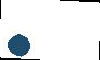

In [176]:
inv_transform = transforms.ToPILImage()

imgs_tensor, labels_tensor = next(iter(train_dataloader))
img_pil = inv_transform(imgs_tensor[0])
print (labels_tensor[0])
img_pil

# Criando modelo, otimizador e função perda

In [268]:
backbone = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
    nn.MaxPool2d(kernel_size=3),
    nn.ReLU(),
    nn.Flatten()
)

shape_saida = backbone(next(iter(train_dataloader))[0]).shape
neuronios_saida = int(shape_saida[-1])

model = nn.Sequential(
    backbone,
    nn.Linear(in_features=neuronios_saida, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=2)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Flatten()
  )
  (1): Linear(in_features=168, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=2, bias=True)
)

In [269]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Separando os dados em treino, teste

In [270]:
test_rate = 0.1
test_size = int(test_rate*len(customds))
train_size = len(customds) - test_size

train_ds, test_ds = random_split(customds, lengths=[train_size, test_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_function_dataloader)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=collate_function_dataloader)

print ('train batches: ' + str(len(train_dataloader)))
print ('test batches: ' + str(len(test_dataloader)))

train batches: 23
test batches: 3


In [271]:
def avaliacao(dataloader):
    model.eval()
    with torch.no_grad():
        acertos, total, test_loss = 0, 0, 0
        for imgs_tensor, labels_tensor in dataloader:
            imgs_tensor, labels_tensor = imgs_tensor.to(device), labels_tensor.to(device)
            y_pred = model(imgs_tensor)
            loss = criterion(y_pred, labels_tensor)
            test_loss += loss.item()
            probs = probabilidades(y_pred).argmax(1)
            acertos += int((labels_tensor == probs).sum())
            total += len(labels_tensor)
            
    
    return test_loss, acertos/total

avaliacao(iter(test_dataloader))

(2.088132083415985, 0.45)

# Treinamento

In [272]:
epochs = 30

resultados = []

print ('{}  {}  {}  {}'.format('epoch', 'train_loss', 'test_loss', 'test_accu'))

for epoch in range(epochs):

    model.train()

    train_loss, acuracy_loss = 0, 0

    for imgs_tensor, labels_tensor in train_dataloader:

        optimizer.zero_grad()

        y_pred = model(imgs_tensor)

        loss = criterion(y_pred, labels_tensor)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
    
    test_loss, test_accu = avaliacao(test_dataloader)

    print ('{:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}'.format(epoch, train_loss, test_loss, test_accu))
    resultados.append([epoch, train_loss, test_loss, test_accu])

resultados = np.array(resultados)
print ('fim')

epoch  train_loss  test_loss  test_accu
0.00  15.97  2.09  0.45
1.00  15.97  2.07  0.45
2.00  15.96  2.09  0.45
3.00  15.94  2.09  0.45
4.00  15.94  2.09  0.45
5.00  15.86  2.07  0.35
6.00  15.75  2.06  0.60
7.00  15.56  1.91  0.50
8.00  14.97  1.93  0.65
9.00  14.73  1.91  0.70
10.00  13.22  1.56  0.80
11.00  12.81  1.80  0.70
12.00  11.18  1.54  0.70
13.00  10.10  1.21  0.90
14.00  8.19  0.89  0.85
15.00  6.54  1.16  0.80
16.00  5.08  1.84  0.75
17.00  7.31  0.79  0.85
18.00  4.52  0.92  0.80
19.00  4.55  0.82  0.80
20.00  3.89  1.16  0.80
21.00  3.56  0.67  0.85
22.00  3.32  0.65  0.85
23.00  1.79  0.39  0.90
24.00  2.12  0.41  0.95
25.00  2.01  0.28  0.95
26.00  2.08  0.29  0.95
27.00  3.05  1.05  0.85
28.00  1.96  0.71  0.85
29.00  1.57  0.11  1.00
fim


# Visualizando resultados

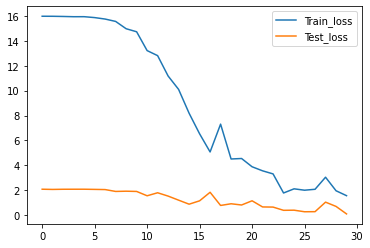

In [273]:
plt.plot(resultados[:,0], resultados[:,1], label='Train_loss')
plt.plot(resultados[:,0], resultados[:,2], label='Test_loss')
plt.legend()
plt.show()

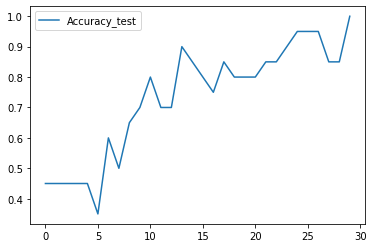

In [274]:
plt.plot(resultados[:,0], resultados[:,3], label='Accuracy_test')
plt.legend()
plt.show()

# Criando uma função que faz inferência a partir de uma imagem

In [340]:
def inferencia(imagem):
    img_h_tensor, img_w_tensor = 60, 100
    transformer = transforms.Compose([
        transforms.Resize((img_h_tensor, img_w_tensor)),
        transforms.ToTensor()
    ])
    probs =nn.Softmax(dim=1)
    img_tensor = transformer(imagem)
    img_tensor.unsqueeze_(0)
    y_pred = model(img_tensor)
    y_pred = probs(y_pred)
    indice_pred = int(y_pred.argmax(1)[0])  # [0] porque só estou mandando uma imagem e o retorno vem num vetor

    label = idx2label[indice_pred]
    prob_pred = round(float(probs(y_pred)[0][indice_pred]), 2)

    print ('Predito: ' + label)
    print ('prob: ' + str(prob_pred))

inferencia(retornar_imagem())

retornou quadrado
Predito: square
prob: 0.72


In [341]:
torch.save(model, 'modelo.pt')